<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/models/ssimloss/eighth_size_256.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
from keras.utils import load_img
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random

from google.colab import userdata

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [2]:
!pip install pytorch-msssim
from pytorch_msssim import ms_ssim

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [3]:

!git clone https://{userdata.get('token')}@github.com/StuartLiv/CPSC-440-Project
%pwd

/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `git config --global user.email {userdata.get('email')}'
/bin/bash: -c: line 1: syntax error near unexpected token `('
/bin/bash: -c: line 1: `git config --global user.name {userdata.get('name')}'
Cloning into 'CPSC-440-Project'...
remote: Enumerating objects: 166346, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 166346 (delta 41), reused 31 (delta 13), pack-reused 166262
Receiving objects: 100% (166346/166346), 781.85 MiB | 44.21 MiB/s, done.
Resolving deltas: 100% (36919/36919), done.
Updating files: 100% (249460/249460), done.


'/content'

In [4]:
!git config --global user.email {userdata.get('email')}
!git config --global user.name {userdata.get('name')}

# 2. Preprocess data

Datasets:
- `medset_multisize`
  - Single datasets. Dataset construction code in repo too
  - 12000 Images, in randomized order
  - Res 256x256 (grayscale images also available in 128x128, 64x64, 32x32)


In [5]:
''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = load_img(path + '/'+i)
    arr.append(img_to_array(img) / 255)

  return np.array(arr)


Load datasets, partition sets, and make tensors in color-layer order for convolutions



In [6]:
training_proportion = 0.8
validation_proportion = 0.0

def load_and_partition(path):
  arr = make_image_arr(path)
  cutoff = int(len(arr)*training_proportion)
  return arr[:cutoff], arr[cutoff:]

def make_tensor(arr):
  #Axis transformation: Shape (n, h, w, 3) -> (n, 3, h, w)
  #Inversion is np.moveaxis(arr, [2,2], [1,1])
  return torch.from_numpy(np.moveaxis(arr, [3,1], [1,2]))


#Extract single channel, since all 3 are the same in gray images
def make_gray_tensor(arr):
  return make_tensor(arr)[:, 0:1, :, :]

color_train, color_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/color')
gray_train, gray_test = load_and_partition('/content/CPSC-440-Project/datasets/medset_multisize/gray32')

assert(len(color_train) == len(gray_train) and len(color_test) == len(gray_test))
n_train = len(color_train)
n_test = len(color_test)

color_train_tensors = make_tensor(color_train)
color_test_tensors = make_tensor(color_test)

gray_train_tensors = make_gray_tensor(gray_train)
gray_test_tensors = make_gray_tensor(gray_test)

100%|██████████| 12000/12000 [00:02<00:00, 5455.72it/s]


# 3. Model
Model generated below:

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Conv2d(8, 3, 3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()

Load stored decoder from full size model training, and fix decoder parameters.

In [8]:
autoencoder.decoder = torch.load('/content/CPSC-440-Project/models/decoder_weights_256')
for param in autoencoder.decoder.parameters():
  param.requires_grad = False

(optionally) load pre-trained encoder

In [ ]:
autoencoder.encoder = torch.load('/content/CPSC-440-Project/models/32_dim_encoder_weights')

Train Model (SGD)

In [9]:
criterion = ms_ssim
optimizer = optim.Adam(autoencoder.encoder.parameters(), lr=0.001)
autoencoder.train()
autoencoder.to(device)

# Training loop
num_epochs = 5
num_iterations = 1000
batch_size=32
for epoch in range(num_epochs):
  for iteration in range(num_iterations):
      running_loss = 0.0
      batch_indexes = torch.randint(high=n_train, size=(batch_size,1))

      inputs = gray_train_tensors[batch_indexes].squeeze(1).to(device)
      targets = color_train_tensors[batch_indexes].squeeze(1).to(device)

      outputs = autoencoder(inputs)
      loss = criterion(outputs, targets)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
  print('[%d] loss: %.5f' % (epoch+1, running_loss / batch_size))

print('Finished Training')

[1] loss: 0.03117
[2] loss: 0.03117
[3] loss: 0.03116


KeyboardInterrupt: 

Simple Image Space Exploration

i: 646
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.1238, grad_fn=<MseLossBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([3, 256, 256])) that is different to the input size (torch.Size([1, 3, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


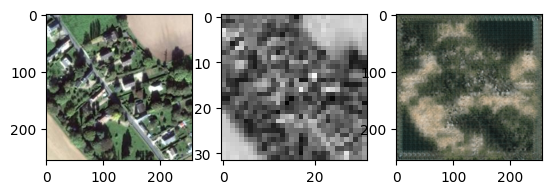

i: 212
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.2077, grad_fn=<MseLossBackward0>)


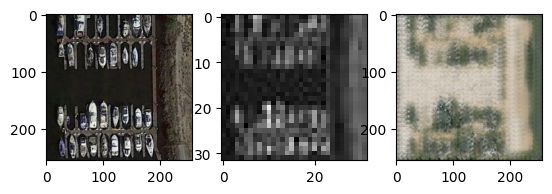

i: 242
LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT
tensor(0.2934, grad_fn=<MseLossBackward0>)


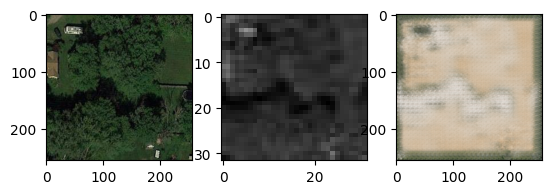

In [10]:
autoencoder.eval()
for i in np.random.randint(n_test,size=3):
  image_bw = gray_test[i]
  image_c = color_test[i]

  # Colorize the image
  t = gray_test_tensors[i].unsqueeze(0).to(device)
  colorized_image = autoencoder(t)
  colorized_image_format = np.moveaxis(colorized_image.squeeze().cpu().detach().numpy(), [1,2], [0,1])

  print("i:", i)
  print("LEFT TO RIGHT: ORIGINAL, DOWNSIZED GRAYSCALE INPUT, COLORIZED OUTPUT")
  print(nn.MSELoss()(colorized_image.cpu(), color_test_tensors[i]))

  plt.subplot(1,3,1)
  plt.imshow(image_c)
  plt.subplot(1,3,2)
  plt.imshow(image_bw)
  plt.subplot(1,3,3)
  plt.imshow(colorized_image_format)
  plt.show()

Save current model

In [20]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/models/ssimloss/32_dim_encoder_weights')

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [22]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [23]:
!git add .

In [24]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	new file:   models/ssimloss/32_dim_encoder_weights



In [25]:
!git commit -m "32x32 size model weights (3 epochs with msssim loss)"

[main 7ccb49b4b] 32x32 size model weights (3 epochs with msssim loss)
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 models/ssimloss/32_dim_encoder_weights


In [26]:
!git push

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 16 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 15.48 KiB | 15.48 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/StuartLiv/CPSC-440-Project
   3d5e6f2af..7ccb49b4b  main -> main


# 4. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!